In [1]:
import pandas as pd   
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import datetime

## 1. Brief Recap of Last Session

Last week we introduced Pandas DataFrames and Series objects. Let's start off with a few exercises to review some of the concepts we talked about last week:

1). Using np.random.normal(size=(rows, columns)), construct a Pandas DataFrame with columns 'a', 'b', 'c' (use the default integer index). 

2). Before doing any experiments, what is the probability that a row in your DataFrame satisfies (a>0, b>0, c<0)? 

3). Using what you know about filtering DataFrames, test your prediction. If you repeat the experiment and make 'rows' larger when you construct the DataFrame, what do you see?

4). Write a little function that only returns positive normal random variables. In other words, your function should first generate a candidate normal random variable, discard it if it isn't positive, then try again, etc. Now, add a new column to your DataFrame, 'd', with only positive normal random variables. Find the number of rows such that a,b>d, and c<d. 

5). You now have a df with 4 columns. Construct a Pandas Series called Sers with the same index as your df; if a,b>d and c<d, the corresponding entry in Sers should be equal to d. Otherwise, it should be a^2+b^2+c^2. 

## Introduction to matplotlib:

Below is a simple example for plotting numpy arrays in matplotlib:

In [17]:
def gen_trig_data(sig, T, Tmax, N=1000):
    '''
    Generate y=cos(w*x)+sig*err.
    T is the period, Tmax is the number of time points we run for. 
    N is number of data points. 
    '''
    w = (2.*np.pi)/T
    x = np.linspace(0, Tmax, N)
    y = np.cos(w*x)+sig*np.random.normal(size=N)
    return x,y

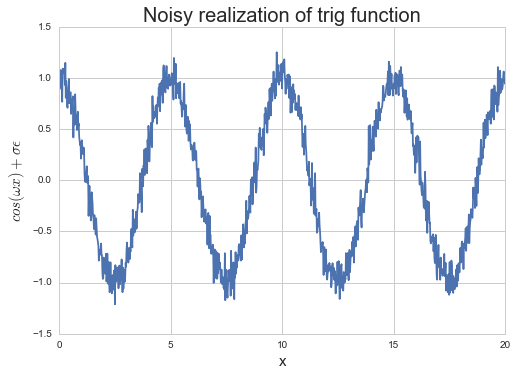

In [18]:
x,y = gen_trig_data(0.1, 5., 4*5.)
plt.plot(x,y)
plt.title("Noisy realization of trig function",fontsize=20)
plt.xlabel("x",fontsize=15)

# We can use math typesetting in axis labels:
plt.ylabel(r'$cos(\omega x)+\sigma \epsilon$',fontsize=15)

If our data is stored in pandas objects, we can also plot very easily:

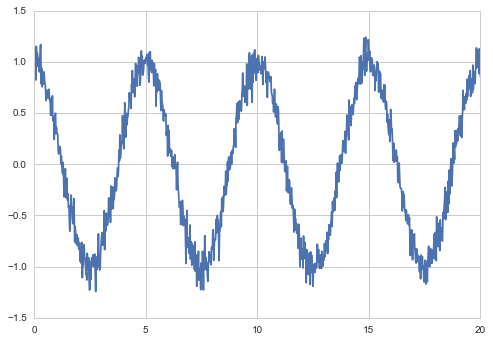

In [19]:
x,y = gen_trig_data(0.1, 5., 4*5)
# List comprehension + dict as constructor of pandas series:
trig_series = pd.Series({i:j for (i,j) in zip(x,y)})
trig_series.plot()

We can plot data on the same axis using multiple columns in a dataframe:

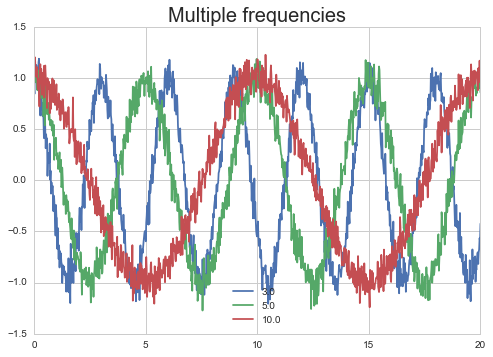

In [27]:
trig_df = {}
for n in [3.,5.,10.]:
    x,y = gen_trig_data(0.1, n, 20)
    trig_df[n] = pd.Series(y,index=x)

trig_df = pd.DataFrame(trig_df)
trig_df.plot()
plt.title("Multiple frequencies",fontsize=20)

We can visualize the data as a histogram too. Can you explain the x-axis, y-axis below?

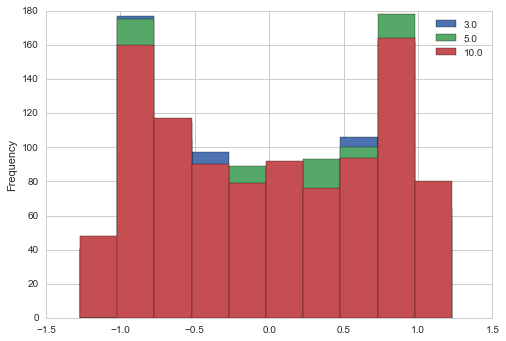

In [29]:
trig_df.plot(kind='hist')

We can smooth out the plot above by using a 'kernel density estimator' (this depends on an important parameter known as bandwidth--instead of varying this parameter, we can use the default provided by pandas):

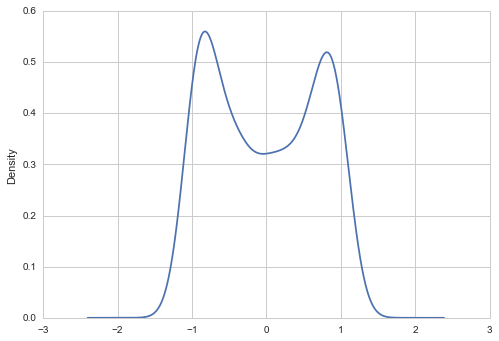

In [32]:
trig_df[3.0].plot(kind='kde')

## TODO: 

Your friend is generating random numbers one of two ways: 
1). sample x from $N(\mu, \sigma)$ and return absolute value of x. 
2). Generate a proposal x' by sampling from $N(\mu, \sigma)$. If $x'<0$, discard and try again, until $x'>0$ and then return $x=x'$. 

Are these approaches the same? Generate 1000 random variables from approach 1 and approach 2, and compare the two by plotting e.g. histograms or kernel density estimates:

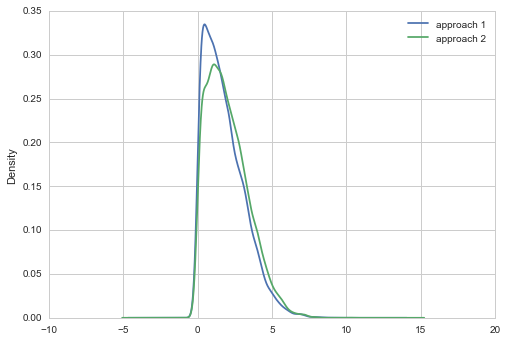

In [45]:
# Approach 1:
def gen_approach1(mu, sig, n):
    v1 = np.abs(sig*np.random.normal(size=n)+mu)
    return v1

def gen_approach2(mu, sig, n):
    v2 = []
    for i in range(n):
        x_prime = -100
        while x_prime<0:
            x_prime = sig*np.random.normal()+mu
        v2.append(x_prime)
    return v2

n = 10000
mu = 1.0
sig = 2.0

df_samples = pd.DataFrame(
    {'approach 1':gen_approach1(mu, sig, n),
     'approach 2':gen_approach2(mu, sig, n)})
df_samples.plot(kind='kde')

We can also summmarize data with bar plots--one obvious application of this is when we have a categorical instance and we'd like to count instances within a dataset that fall into each bucket. As an example, consider grading on a curve: test scores in a class can be modeled as a random variable using 'approach 2' above. We'll compute grades as a scale based on the mean and standard deviation of test results:

In [88]:
def return_grade_counts(grades):
    '''
    Try modifying this to make a more 'fair' grading scheme!
    '''
    mu = np.mean(grades)
    sig = np.std(grades)
    grades = ((grades-mu)/sig).astype(int)
    
    letter_grades = {}
    letter_grades['F'] = len(grades[grades<-1])
    letter_grades['D'] = len(grades[grades==-1])
    letter_grades['C'] = len(grades[grades==1])
    letter_grades['B'] = len(grades[grades==2])
    letter_grades['A'] = len(grades[grades>=3])
    return letter_grades

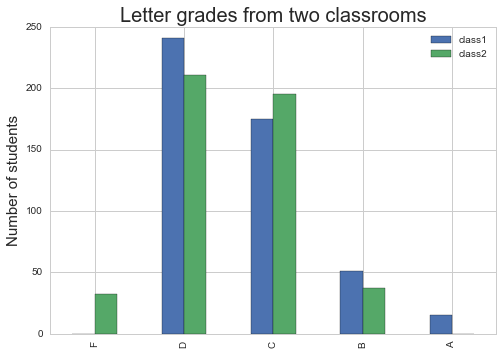

In [90]:
## Two classrooms, where the tests follow different distributions:
v1 = gen_approach2(mu=0.0,sig=1.0,n=1500)
v2 = np.random.normal(size=1500)

grade_df = pd.DataFrame({
        'class1':return_grade_counts(v1),
        'class2':return_grade_counts(v2)
    })
index_order = ['F','D','C','B','A']
grade_df.loc[index_order].plot(kind='bar')
plt.title("Letter grades from two classrooms",fontsize=20)
plt.ylabel("Number of students",fontsize=15)

## Spotify data:

In [144]:
%%time
## Here, we'll load, preprocess and prep a dataframe:
## Feel free to explore these functions in more detail:

data_dir = '../datasets/kworb/'
artists = pd.read_csv(data_dir + 'artists.csv')
tracks = pd.read_csv(data_dir + 'tracks.csv')

# Formatting:
tracks['TrackUrl'] = tracks['Track_href'].apply(lambda x:x[3:])

track_daily = pd.read_csv(data_dir + 'track_daily.csv')

numeric_cols = [c for c in track_daily.columns if c!='TrackUrl']
track_daily[numeric_cols] = track_daily[numeric_cols].apply(
    lambda sers: pd.to_numeric(sers.str.replace(",",""), errors='coerce'))

CPU times: user 32.9 s, sys: 3.91 s, total: 36.8 s
Wall time: 36.3 s


In [145]:
# Shows track plays per day:
# Unfortunately, we need to back out what track url corresponds to what artist:
track_daily[['Date','TrackUrl']].head()

,Date,TrackUrl
0,NaN,track/1jptfRmRAdxA2REY3GBY3C.html
1,NaN,track/1jptfRmRAdxA2REY3GBY3C.html
2,NaN,track/2Vdub5mY4lad7w64bFPUez.html
3,NaN,track/2Vdub5mY4lad7w64bFPUez.html
4,20170316.0,track/2Vdub5mY4lad7w64bFPUez.html


In [146]:
tracks_and_artists = tracks.merge(artists[['Name','Url']], left_on='ArtistUrl',right_on='Url')

# Find unique tracks:
unique_tracks = tracks_and_artists[np.invert(tracks_and_artists['TrackUrl'].duplicated())][['Name','TrackUrl','Track_name']]
artist_track_daily = track_daily.merge(unique_tracks, left_on='TrackUrl',right_on='TrackUrl')

In [147]:
artist_track_daily.groupby('Name').aggregate({'US':np.sum,'CO':np.sum}).dropna(how='all').fillna(0.0).head()

,CO,US
Name,,
*NSYNC,0.0,2865030.0
2 Chainz,0.0,98460128.0
21 Savage,0.0,839284364.0
5 Seconds of Summer,84724.0,147338219.0
50 Cent,0.0,276012.0


In [148]:
artist_track_daily.groupby('Track_name').aggregate({'US':np.sum,'CO':np.sum}).dropna(how='all').fillna(0.0).head()

,CO,US
Track_name,,
"""Hit the Quan"" #HTQ",0.0,7263760.0
#Beautiful,0.0,15126013.0
#SELFIE,1007921.0,20120459.0
#icanteven,0.0,8154451.0
#thatPOWER,0.0,6336099.0


## Data visualization of spotify data:

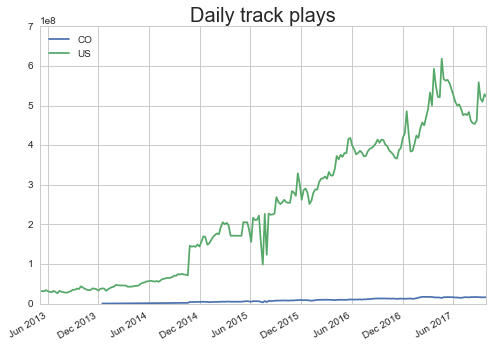

In [149]:
daily_aggregate = artist_track_daily[np.isfinite(artist_track_daily['Date'])].groupby('Date').aggregate({'US':np.sum,'CO':np.sum})
daily_aggregate.index = daily_aggregate.index.map(lambda x:pd.to_datetime(str(int(x)),format='%Y%m%d'))
daily_aggregate.plot()
plt.title("Daily track plays",fontsize=20)

### TODO: How long does it take a song to peak? Do different artists' songs peak faster than others? If an artist has had a popular song before, will his/her new song peak faster than before? Related: how long does it take a song to go away once it has peaked? Is there any relationship between 'time to peak' and 'time to disappear'?

### Compare two songs below, The Fix and Despacito:

In [190]:
#song = np.random.choice(artist_track_daily['Track_name'])
#song= 'The Fix'
song='Despacito - Remix'
song_df = artist_track_daily[
    (artist_track_daily['Track_name']==song) & (np.isfinite(artist_track_daily['Date']))].set_index('Date')[['US','Name']]
song_df.index = song_df.index.map(lambda x:pd.to_datetime(str(int(x)),format='%Y%m%d'))

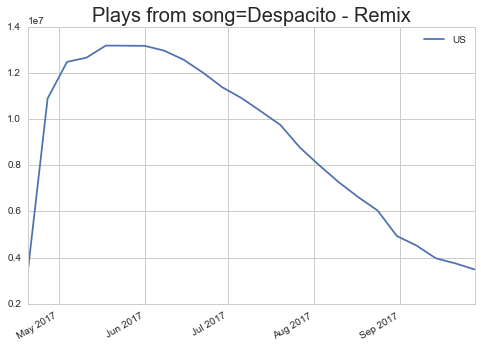

In [191]:
song_df.fillna(0.0).plot()
plt.title("Plays from song={}".format(song),fontsize=20)

In [187]:
## How to see all the songs a certain artist has in the dataset?
set(artist_track_daily[artist_track_daily['Name']=='Justin Bieber']['Track_name'])

{'#thatPOWER',
 '2U',
 'All Around The World',
 'All I Want For Christmas Is You (SuperFestive!) Duet with Mariah Carey',
 'All In It',
 'All That Matters',
 'As Long As You Love Me',
 'As Long As You Love Me - Acoustic Version',
 'Baby',
 'Backpack',
 'Beauty And A Beat',
 'Beauty And A Beat - Acoustic Version',
 'Been You',
 'Boyfriend',
 'Boyfriend - Acoustic Version',
 'Children',
 'Christmas Eve',
 'Christmas Love',
 'Cold Water',
 'Cold Water - Afrojack Remix',
 'Company',
 'Deja Vu',
 'Despacito - Remix',
 'Drummer Boy',
 'Friends',
 'Get Used To It',
 'Heartbreaker',
 'Hold Tight',
 'Home To Mama',
 "I'll Show You",
 "I'm the One",
 'Juke Jam',
 'Let Me Love You',
 'Let Me Love You - Don Diablo Remix',
 'Let Me Love You - Marshmello Remix',
 'Let Me Love You - Sean Paul Remix',
 "Let Me Love You - Ti\xc3\xabsto's AFTR:HRS Mix",
 'Let Me Love You - Zedd Remix',
 'Life Is Worth Living',
 'Lolly',
 'Love Yourself',
 'Mark My Words',
 'Mistletoe',
 'No Pressure',
 'No Sense',
 'Pur